# Predictions on Titanic dataset
### The main goal is to make predictions on whether the passenger of  Titanic survived the shipwreck or not, to do this i will use datased composed of 9 predictors, and 1 target variable which indicates survival of the passengers
### The metod i'll be using to do this is a simple logistical regression, which works very well for this kind of classification problems
Data source: https://www.kaggle.com/competitions/titanic/data

In [217]:
"""Import of all needed packages and functions"""
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_auc_score, RocCurveDisplay, roc_curve

In [218]:
"""Import of both train, and test data(test_data is imported for kaggle competition purposes)"""
train_data=pd.read_csv('train.csv',index_col=0)
test_data=pd.read_csv('test.csv',index_col=0)

## Data preprocessing


In [219]:
"""A quick overview of the data structure"""
print(train_data.info())
train_data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### You can notice that it is possible to extract titles like 'Mr.', or 'Miss.', from the Name column, those titles might be useful as a another unique predictor for the model




In [220]:
"""Identification of all possible titles in train dataset"""
for i in range(1,train_data.shape[0]+1):
    t=re.findall(r"\w+\.",train_data.loc[i,'Name'])
    str_t=str(t[0])
    if train_data.loc[i,'Name']!=None:
        train_data.loc[i,'Title']=str_t
    else:
        train_data.loc[i,'Title']=None

In [221]:
"""Identification of all possible titles in kaggle test dataset"""
for i in range(892,892+test_data.shape[0]):
    t=re.findall(r"\w+\.",test_data.loc[i,'Name'])
    str_t=str(t[0])
    if test_data.loc[i,'Name']!=None:
        test_data.loc[i,'Title']=str_t
    else:
        test_data.loc[i,'Title']=None

In [222]:
"""There are many individual titles that are not really necessary, so lets replace them with more 'general' titles"""
print(train_data['Title'].value_counts())


Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: Title, dtype: int64


In [223]:
def replace_titles(x):
    title=x['Title']
    if title in ['Don.', 'Major.', 'Capt.', 'Jonkheer.', 'Rev.', 'Col.','Sir.']:
        return 'Mr.'
    elif title in ['Countess.', 'Mme.','Lady.','Dona.']:
        return 'Mrs.'
    elif title in ['Mlle.', 'Ms.']:
        return 'Miss.'
    elif title =='Dr.':
        if x['Sex']=='Male':
            return 'Mr.'
        else:
            return 'Mrs.'
    else:
        return title
train_data['Title']=train_data.apply(replace_titles, axis=1)
test_data['Title']=test_data.apply(replace_titles, axis=1)

In [224]:
"""Columns SibSp and Parch means correspondingly number of siblings on the ship, and number of parents on the ship, 
since these two columns are very similar they could be turned into one, to prevent future potential collinearity"""
train_data['Alone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
test_data['Alone']=np.where((test_data["SibSp"]+test_data["Parch"])>0, 0, 1)

In [225]:
"""There are some empty rows in the dataset"""
print(train_data.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
Alone         0
dtype: int64


In [226]:
age_nan=(train_data['Age'].isna().sum() / train_data.shape[0]) * 100
cabin_nan=(train_data['Cabin'].isna().sum() / train_data.shape[0]) * 100
print(f'{round(age_nan,2)}% of data in Age column is empty') 
print(f'{round(cabin_nan,2)}% of data in Cabin column is empty')

19.87% of data in Age column is empty
77.1% of data in Cabin column is empty


In [227]:
"""Since majority of the data in Cabin column is empty it's reasonable to delete whole column,
in the Embarked column there are only 2 empty rows so there is no need to remove whole column as well"""
train_data.drop('Cabin',axis=1,inplace=True)
train_data.dropna(axis=0,subset=['Embarked'],inplace=True)

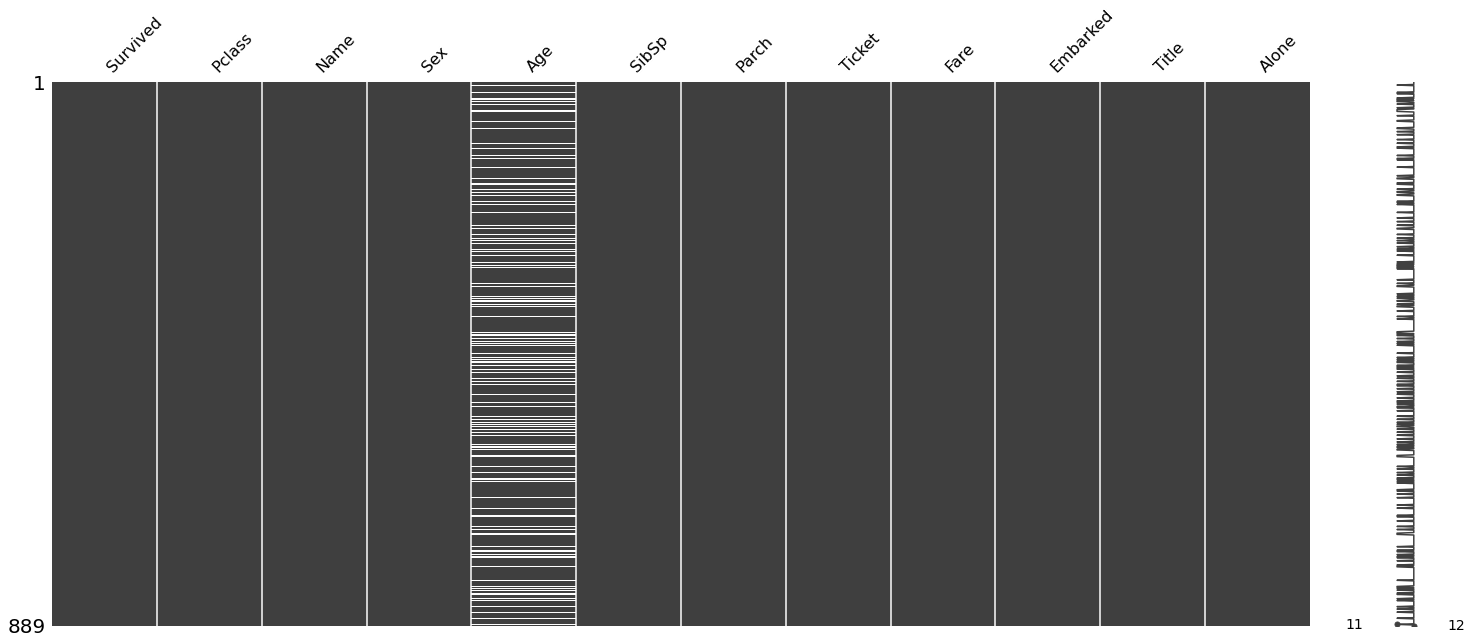

In [228]:
msno.matrix(train_data) 
plt.show()

Looks like missing values for 'Age' column are distributed quite randomly

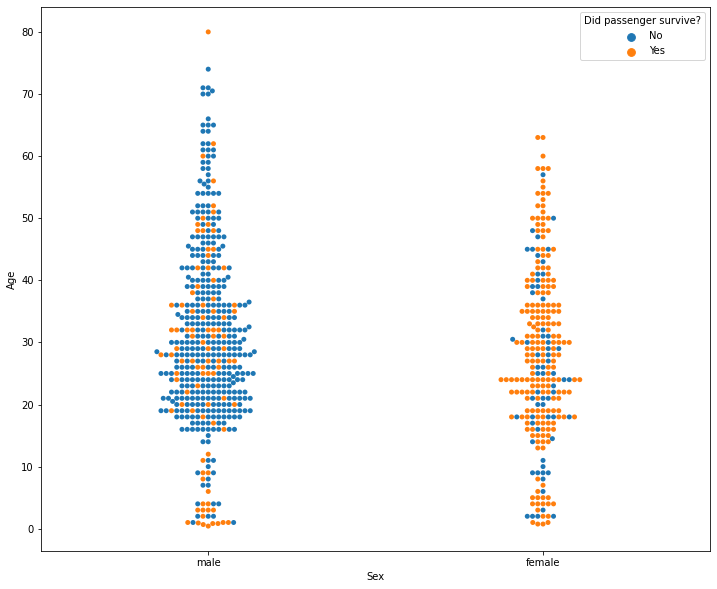

In [229]:
plt.figure(figsize=(12,10))
ax=sns.swarmplot(y='Age',x='Sex',hue='Survived',data=train_data)
h, l = ax.get_legend_handles_labels()
ax.legend(h,["No",'Yes'], title="Did passenger survive?")
plt.show()

It seems that survivability is somehow correlated with passenger sex, however its hard to say whether the combination of age and sex of the passenger also affects if he survived

In [230]:
"""It's possible that age somehow affects the survivability so i'll impute all the empty cells in that column with a proper mean value"""
male_1 = round(train_data.loc[(train_data['Survived']==1) & (train_data['Sex']=='male'),"Age"].mean(),1)
male_0 = round(train_data.loc[(train_data['Survived']==0) & (train_data['Sex']=='male'),"Age"].mean(),1)
female_1 = round(train_data.loc[(train_data['Survived']==1) & (train_data['Sex']=='female'),"Age"].mean(),1)
female_0 = round(train_data.loc[(train_data['Survived']==0) & (train_data['Sex']=='female'),"Age"].mean(),1)

imp_m1 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=male_1)
imp_m0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=male_0)
imp_f1 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=female_1)
imp_f0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=female_0)

train_data.loc[(train_data['Survived']==1) & (train_data['Sex']=='male'),:] = imp_m1.fit_transform(train_data.loc[(train_data['Survived']==1) & (train_data['Sex']=='male'),:])
train_data.loc[(train_data['Survived']==0) & (train_data['Sex']=='male'),:] = imp_m0.fit_transform(train_data.loc[(train_data['Survived']==0) & (train_data['Sex']=='male'),:])
train_data.loc[(train_data['Survived']==1) & (train_data['Sex']=='female'),:] = imp_f1.fit_transform(train_data.loc[(train_data['Survived']==1) & (train_data['Sex']=='female'),:])
train_data.loc[(train_data['Survived']==0) & (train_data['Sex']=='female'),:] = imp_f0.fit_transform(train_data.loc[(train_data['Survived']==0) & (train_data['Sex']=='female'),:])

In [231]:
"""Imputation also needs to be done in the train dataset"""
male = round(test_data.loc[(test_data['Sex']=='male'),"Age"].mean(),1)
female= round(test_data.loc[ (test_data['Sex']=='female'),"Age"].mean(),1)

imp_m = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=male)
imp_f = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=female)

test_data.loc[(test_data['Sex']=='male'),:] = imp_m1.fit_transform(test_data.loc[(test_data['Sex']=='male'),:])
test_data.loc[(test_data['Sex']=='female'),:] = imp_f0.fit_transform(test_data.loc[(test_data['Sex']=='female'),:])

### Now since datasets have no more empty values it's time to do some more EDA

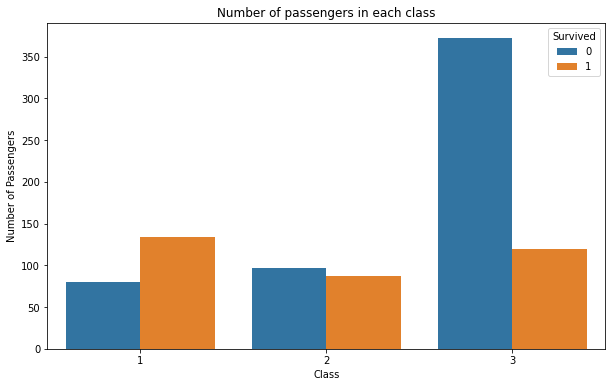

In [232]:
plt.figure(figsize=(10,6))
ax=sns.countplot(x='Pclass', data=train_data, hue='Survived').set(title='Number of passengers in each class',xlabel="Class",ylabel="Number of Passengers")
plt.show()

The 'class' clearny affects the survivability

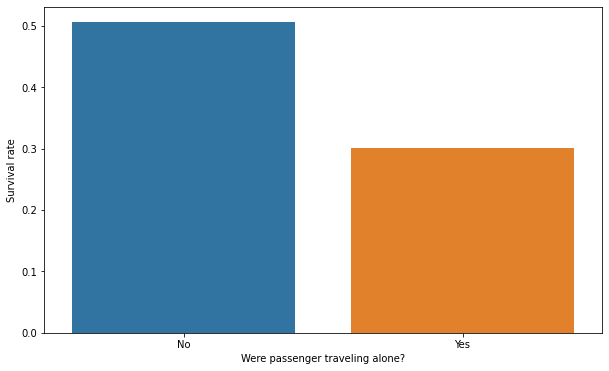

In [233]:
plt.figure(figsize=(10,6))
ax=sns.barplot(x='Alone',y='Survived',data=train_data, ci=None).set(xlabel='Were passenger traveling alone?',ylabel="Survival rate")
plt.xticks([0,1],["No","Yes"])
plt.show()

Looks that passengers who travelled alone had moderately less chances to survive

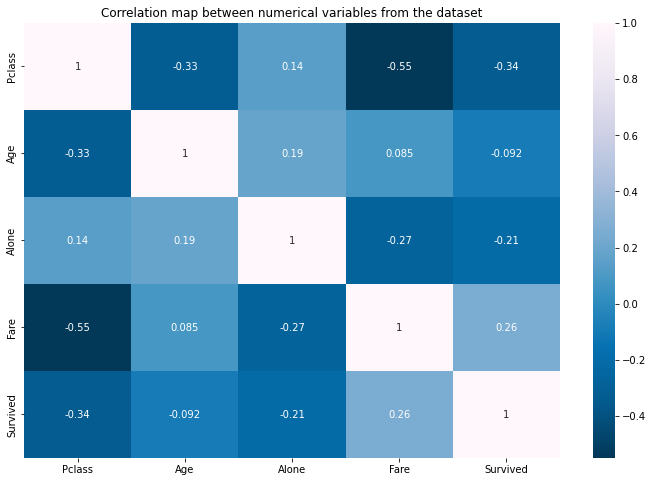

In [234]:
plt.figure(figsize=(12,8))
c=train_data[['Pclass','Age','Alone','Fare','Survived']]
correlation=c.corr()
sns.heatmap(correlation,annot=True,cmap = "PuBu_r").set(title='Correlation map between numerical variables from the dataset')
plt.show()

From the heatmap it seems like there is no clear linear correlation between survivability and the rest separate variables


## Model creation

In [235]:
"""Finally it's time to make a model, firstly it's needed to designate all predictors, and turn them to a numerical variables
since some of them are categorical"""
features= ['Pclass','Age','Sex','Fare','Embarked','Title','Alone']
training=pd.get_dummies(train_data[features],drop_first=True)
print(training.head())

             Pclass   Age     Fare  Alone  Sex_male  Embarked_Q  Embarked_S  \
PassengerId                                                                   
1                 3  22.0   7.2500      0         1           0           1   
2                 1  38.0  71.2833      0         0           0           0   
3                 3  26.0   7.9250      1         0           0           1   
4                 1  35.0  53.1000      0         0           0           1   
5                 3  35.0   8.0500      1         1           0           1   

             Title_Miss.  Title_Mr.  Title_Mrs.  
PassengerId                                      
1                      0          1           0  
2                      0          0           1  
3                      1          0           0  
4                      0          0           1  
5                      0          1           0  


In [236]:
"""Train test split is used so all the evaluation metrics can be measured on the separete X_test and y_test datasets
(in fact this has nothing to do with test_data from the kaggle which is just another dataset)"""
X=training
y=train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
model=LogisticRegression(solver='lbfgs', max_iter=1000)

In [237]:
"""Coefficients of the model"""
model.fit(X_train,y_train)
print('Intercept: ')
print(round(model.intercept_[0],3),'\n')
print('Coefficients:')
for a,b in zip(model.feature_names_in_,model.coef_[0]):
    print(f'{a}: {b:.3f}')

Intercept: 
4.855 

Coefficients:
Pclass: -1.128
Age: -0.026
Fare: 0.000
Alone: 0.365
Sex_male: -1.277
Embarked_Q: 0.064
Embarked_S: -0.460
Title_Miss.: -0.550
Title_Mr.: -1.762
Title_Mrs.: 0.072


In [238]:
predictions=model.predict(X_test)
print('Precision of the predictions: ',round(precision_score(y_test,predictions),3))
print('Accuracy of the predictions: ',round(accuracy_score(y_test,predictions),3))

Precision of the predictions:  0.779
Accuracy of the predictions:  0.852


Accuracy and precision both fluctuate around 0.8 so the model is pretty good

In [239]:
results = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(results)

[0.79775281 0.82022472 0.78651685 0.7752809  0.83615819]


Accuracy from cross validation also fluctuates aroud 0.8

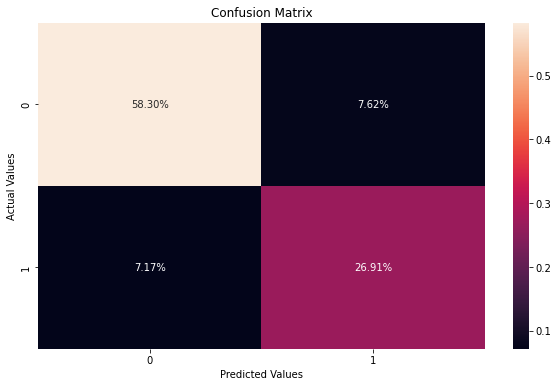

In [240]:
plt.figure(figsize=(10,6))
conf=confusion_matrix(y_test,predictions)
sns.heatmap(conf/np.sum(conf),annot=True,fmt='.2%').set(title="Confusion Matrix",xlabel="Predicted Values",ylabel="Actual Values")
plt.show()

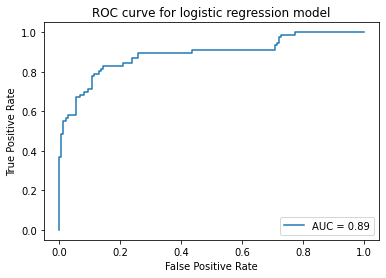

In [241]:
"""Visualization of ROC curve, and AUC score, as another evaluation metric of the model"""
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
display=RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc)
display.plot()
plt.title("ROC curve for logistic regression model")
plt.show()


In [242]:
"""Preparation of the test data from kaggle"""
final_test=pd.get_dummies(test_data[features],drop_first=True)
final_test.isna().sum()

Pclass         0
Age            0
Fare           0
Alone          0
Sex_male       0
Embarked_Q     0
Embarked_S     0
Title_Miss.    0
Title_Mr.      0
Title_Mrs.     0
dtype: int64

In [243]:
final_test['Survived']=model.predict(final_test)
final_test['PassengerId'] = final_test.index
submission=final_test[['PassengerId','Survived']]
submission.to_csv("submission.csv", index=False)

### Overall all of the evaluation metrics for the model score reasonably high, accuracy on predictions for Kaggle competition, is about 0.78 so its very similar to accuracy on 'test data' acquired from splitting the training set



